In [ ]:
!pip install stable_baselines3[extra]
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
import kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


In [ ]:
# Load the dataset
path = kagglehub.dataset_download("jacksoncrow/stock-market-dataset")
print("Path to dataset files:", path)
metadata = pd.read_csv(os.path.join(path, 'symbols_valid_meta.csv'))

100%|██████████| 522M/522M [00:07<00:00, 75.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jacksoncrow/stock-market-dataset/versions/2


In [ ]:
# Choose a stock symbol for demonstration
symbol = 'AAPL'  # Example symbol
file_path = os.path.join(path, 'stocks', f'{symbol}.csv')
data = pd.read_csv(file_path)

In [ ]:
# Display the first few rows of the dataset
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400


In [ ]:
# Preprocess data
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(inplace=True)

In [ ]:
# Feature engineering
data['Price Change'] = data['Close'].pct_change()
data.dropna(inplace=True)
data['Moving Average'] = data['Close'].rolling(window=5).mean()
data.dropna(inplace=True)

In [ ]:
# Normalize the data
data['Normalized Close'] = (data['Close'] - data['Close'].min()) / (data['Close'].max() - data['Close'].min())


In [ ]:
# Define the trading environment
class StockTradingEnv(gym.Env):
    def __init__(self, data):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.current_step = 0
        self.initial_balance = 10000
        self.balance = self.initial_balance
        self.shares_held = 0
        self.total_asset = self.balance
        self.action_space = spaces.Discrete(3)  # Buy, Hold, Sell
        self.observation_space = spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.total_asset = self.balance
        return self._next_observation()

    def _next_observation(self):
        obs = np.array([
            self.data['Normalized Close'].iloc[self.current_step],
            self.data['Price Change'].iloc[self.current_step],
            self.data['Moving Average'].iloc[self.current_step]
        ])
        return obs

    def step(self, action):
        prev_total_asset = self.total_asset
        current_price = self.data['Close'].iloc[self.current_step]

        if action == 0:  # Buy
            self.shares_held += self.balance // current_price
            self.balance %= current_price
        elif action == 2:  # Sell
            self.balance += self.shares_held * current_price
            self.shares_held = 0

        self.total_asset = self.balance + self.shares_held * current_price
        reward = self.total_asset - prev_total_asset

        self.current_step += 1
        done = self.current_step >= len(self.data) - 1
        obs = self._next_observation()

        return obs, reward, done, {}

In [ ]:
# Instantiate the environment
!pip install shimmy>=0.2.1
env = DummyVecEnv([lambda: StockTradingEnv(data)])

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [ ]:
# Initialize the PPO agent
model = PPO("MlpPolicy", env, verbose=1, learning_rate=0.0001, n_steps=2048, batch_size=64, n_epochs=10, clip_range=0.1)

Using cpu device


In [ ]:
# Train the agent
model.learn(total_timesteps=500000)

-----------------------------
| time/              |      |
|    fps             | 676  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 600           |
|    iterations           | 2             |
|    time_elapsed         | 6             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00027211604 |
|    clip_fraction        | 0             |
|    clip_range           | 0.1           |
|    entropy_loss         | -1.1          |
|    explained_variance   | -2.07e-05     |
|    learning_rate        | 0.0001        |
|    loss                 | 5.4e+05       |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000417     |
|    value_loss           | 1.05e+06      |
------------------------------------------

In [ ]:
# Evaluate the agent
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean Reward: {mean_reward}, Std Reward: {std_reward}")

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean Reward: 0.0, Std Reward: 0.0


In [ ]:
# Simulate trading
obs = env.reset()
done = False
profits = []
while not done:
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    profits.append(env.get_attr("total_asset")[0])

In [ ]:
# Calculate additional metrics
returns = np.diff(profits) / profits[:-1]  # Calculate daily returns
cumulative_returns = (1 + returns).cumprod()

# Sharpe Ratio with annualization
risk_free_rate = 0.02  # Example risk-free rate
sharpe_ratio = np.sqrt(252) * np.mean(returns - risk_free_rate) / np.std(returns)

# Maximum Drawdown
peak = profits[0]
max_drawdown = 0
for price in profits:
    if price > peak:
        peak = price
    drawdown = (peak - price) / peak
    if drawdown > max_drawdown:
        max_drawdown = drawdown

print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Maximum Drawdown: {max_drawdown}")

Sharpe Ratio: -13.182446338765397
Maximum Drawdown: 0.9868114547074139


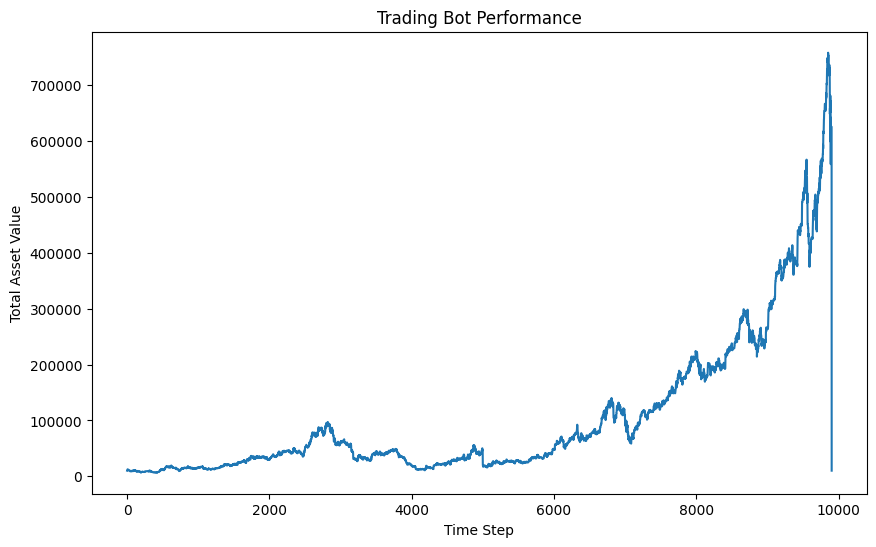

In [ ]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(profits)
plt.xlabel("Time Step")
plt.ylabel("Total Asset Value")
plt.title("Trading Bot Performance")
plt.show()